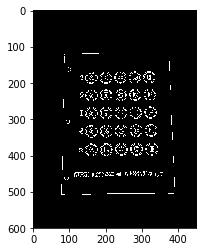

doc found


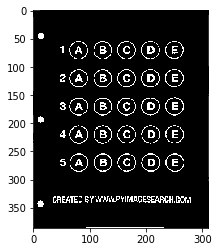

Contorno n: 1


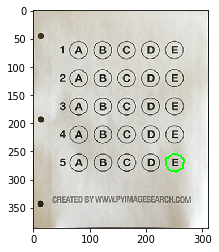

Contorno n: 2


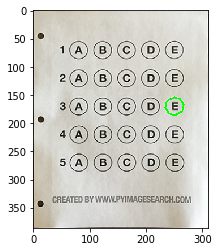

Contorno n: 3


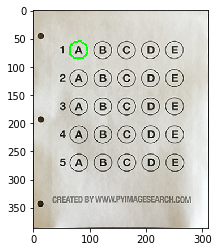

Contorno n: 4


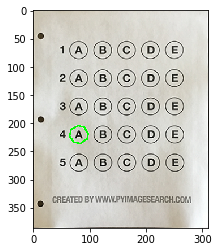

Contorno n: 5


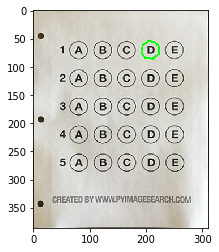

Contorno n: 6


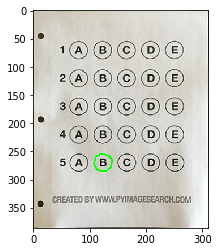

Contorno n: 7


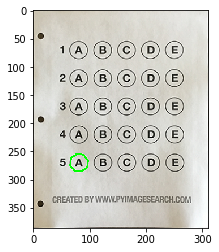

Contorno n: 8


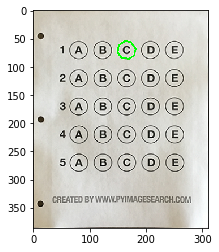

Contorno n: 9


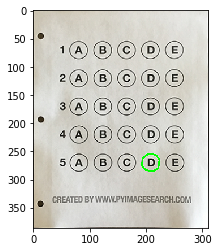

Contorno n: 10


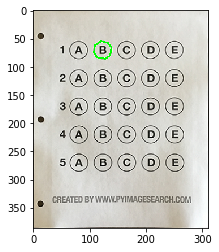

Contorno n: 11


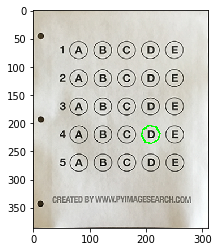

Contorno n: 12


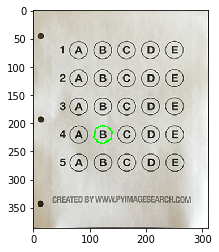

Contorno n: 13


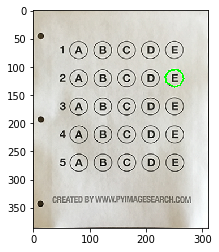

Contorno n: 14


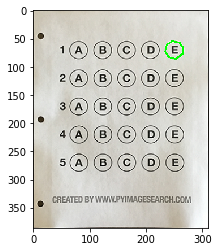

Contorno n: 15


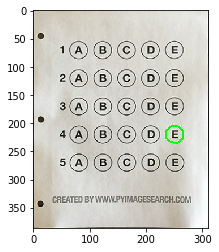

Contorno n: 16


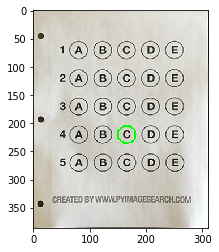

Contorno n: 17


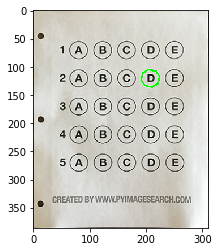

Contorno n: 18


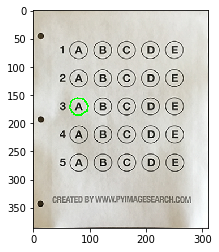

Contorno n: 19


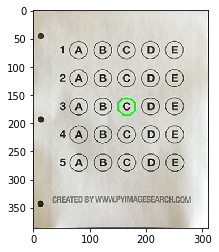

Contorno n: 20


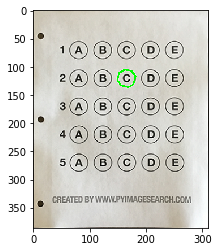

Contorno n: 21


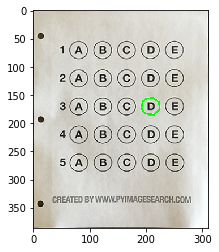

Contorno n: 22


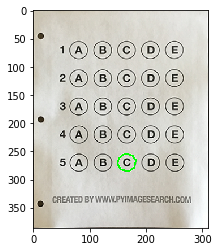

Contorno n: 23


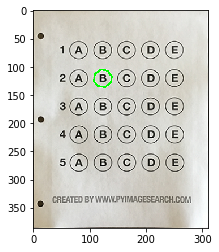

Contorno n: 24


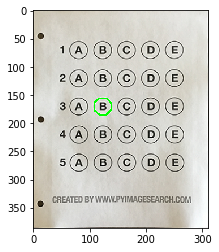

Contorno n: 25


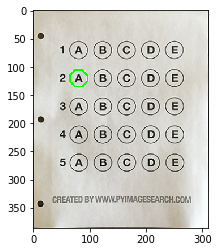

[INFO] score: 0.00%


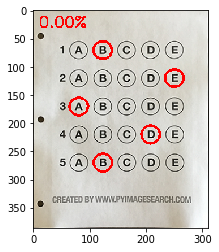

In [11]:
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt


# define the answer key which maps the question number
# to the correct answer
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

image = './images/test_01.png'
image = './images/example_test.png'

# load the image, convert it to grayscale, blur it
# slightly, then find edges
image = cv2.imread(image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)


plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
plt.show()





# find contours in the edge map, then initialize
# the contour that corresponds to the document
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
docCnt = None


for num, c in enumerate(cnts):
    # approximate the contour
    peri = cv2.arcLength(c, True)
    screenCnt = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(screenCnt) == 4:
        print('doc found')
        docCnt = screenCnt
        break
        

# apply a four point perspective transform to both the
# original image and grayscale image to obtain a top-down
# birds eye view of the paper
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

# apply Otsu's thresholding method to binarize the warped
# piece of paper
thresh = cv2.threshold(warped, 0, 255,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
plt.show()


# find contours in the thresholded image, then initialize
# the list of contours that correspond to questions
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
questionCnts = []

cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

for num, c in enumerate(cnts):
    # approximate the contour
    peri = cv2.arcLength(c, True)
    screenCnt = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(screenCnt):
        # show the contour (outline) of the piece of paper
        copy = paper.copy()
        cv2.drawContours(copy, [screenCnt], -1, (0, 255, 0), 2)
        print('Contorno n:', num+1)
        plt.imshow(cv2.cvtColor(copy, cv2.COLOR_BGR2RGB))
        plt.show()
    if num == 24:
        break
   
        
# loop over the contours
for c in cnts:
    # compute the bounding box of the contour, then use the
    # bounding box to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)

    # in order to label the contour as a question, region
    # should be sufficiently wide, sufficiently tall, and
    # have an aspect ratio approximately equal to 1
    # to change based on template
    if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
        questionCnts.append(c)

        
# sort the question contours top-to-bottom, then initialize
# the total number of correct answers

# sort all all the contours based on position

questionCnts = contours.sort_contours(questionCnts,
    method="top-to-bottom")[0]
        
correct = 0
# each question has 5 possible answers, to loop over the
# question in batches of 5
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
    # sort the contours for the current question from
    # left to right, then initialize the index of the
    # bubbled answer
    cnts = contours.sort_contours(questionCnts[i:i + 5])[0]
    bubbled = None
    # loop over the sorted contours
    for (j, c) in enumerate(cnts):
        # construct a mask that reveals only the current
        # "bubble" for the question
        mask = np.zeros(thresh.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)

        # apply the mask to the thresholded image, then
        # count the number of non-zero pixels in the
        # bubble area
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        total = cv2.countNonZero(mask)

        # if the current total has a larger number of total
        # non-zero pixels, then we are examining the currently
        # bubbled-in answer
        if total >= 400 and (bubbled is None or total > bubbled[0]):
            bubbled = (total, j)

    # initialize the contour color and the index of the
    # *correct* answer
    color = (0, 0, 255)
    k = ANSWER_KEY[q]

    # check to see if the bubbled answer is correct
    if bubbled != None:
        if k == bubbled[1]:
            color = (0, 255, 0)
            correct += 1

    # draw the outline of the correct answer on the test
    cv2.drawContours(paper, [cnts[k]], -1, color, 3)

    
    
# grab the test taker
score = (correct / 5.0) * 100
print("[INFO] score: {:.2f}%".format(score))
cv2.putText(paper, "{:.2f}%".format(score), (10, 30),
    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
plt.imshow(cv2.cvtColor(paper, cv2.COLOR_BGR2RGB))
plt.show()
#cv2.waitKey(0)
